## Sentiment Analysis Using NLTK

### Hotel Reviews from Trip Advisor 

<img src="assets/review.png" alt="Hotel Review" style="width:200px">

#### Data source: [TripAdvisor Hotel Reviews](https://www.kaggle.com/datasets/thedevastator/tripadvisor-hotel-reviews)


#### Import Library

In [1]:
import numpy as np # for array, linear algebra
import pandas as pd # for data processing
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.colors as mcolors 
import string
import re
import gensim # representing documents as semantic vectors

### Import NLTK Packages

In [2]:
from nltk import pos_tag # Part-of-Speech (POS) tagging
from nltk.stem import WordNetLemmatizer # lemmatize a word
from nltk.stem.porter import PorterStemmer # Information Retrieval
from nltk.tokenize import word_tokenize # splits sentence into words 
from nltk.tokenize import WhitespaceTokenizer # splits on and discards only whitespace characters
from nltk.corpus import wordnet # large lexical database of English words
from nltk.sentiment.vader import SentimentIntensityAnalyzer # sentiment analyzer
import nltk as nltk

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/eo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/eo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/eo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/eo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Import machine learning models

In [3]:
from matplotlib.cm import ScalarMappable # for colormap 
from matplotlib.lines import Line2D # line segment in (x,y) coordinate space
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # give our figure extra personalities
from textwrap import wrap # modifying the behavior of functions. 
from wordcloud import WordCloud # to visualize text
from sklearn.feature_extraction.text import TfidfVectorizer # converts a collection of raw documents into a matrix
from gensim.test.utils import common_texts # training corpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #  representing documents as a vector
from PIL import Image # import image

# For Machine Learning Model
from sklearn import preprocessing # utility functions
from sklearn.impute import SimpleImputer # replace missing values
from sklearn.ensemble import RandomForestClassifier # learning algorithm Random Forest
from sklearn.linear_model import LogisticRegression # learning algorithm Logistic Regression
from sklearn.model_selection import train_test_split # create training and test data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score
from sklearn import tree # for modeling
from sklearn.metrics import classification_report # for classification report

### Load dataset

In [5]:
df = pd.read_csv('/Users/eo/src/hotel_review_sentiment_analysis_nltk/trip_advisor_reviews.csv', encoding = 'ISO-8859-1')
df.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   S.No.   20491 non-null  int64 
 1   Review  20491 non-null  object
 2   Rating  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


### Data cleaning and preprocessing

In [7]:
df = df.sample(frac = 0.1, replace = False, random_state=42)

In [8]:
#This column is the same as index
df = df.drop(['S.No.'], axis = 1)

In [9]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [12]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/eo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a function to help identify type of the words (adjective, verb, noun, adverb)
Remove ‘empty’ review and words with only 1 letter
Lower all text
Tokenize and split text to words
Remove numbers and stop words ( ‘a’, ‘an’, ‘the’, ‘of’, ‘in’, etc.), to help improve accuracy to give more focus to the important information
Part-of-Speech (POS) tagging: Categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context indicates how the word functions in meaning as well as grammatically within the sentence
Lemmatize the text: transform every word into their root form (caring to care)

In [15]:
# return the wordnet object value
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove \t
    text = text.replace('\t', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stopwords_list]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)

In [16]:
df['Clean_Review'] = df['Review'].apply(lambda x: clean_text(x))
df.head()

,Review,Rating,Clean_Review
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...


In [38]:
# add sentiment analysis

sid = SentimentIntensityAnalyzer()

df['Sentiments'] = df['Clean_Review'].apply(lambda x: sid.polarity_scores(x))

In [40]:
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

In [41]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,0.223,0.490,0.286,0.5367
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.129,0.686,0.185,0.9648
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,0.000,0.572,0.428,0.9217
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,0.057,0.631,0.313,0.9982
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.043,0.644,0.313,0.9816


In [45]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

In [46]:
df['chars'] = df['Clean_Review'].apply(count_chars)
df['Words'] = df['Clean_Review'].apply(count_words)

In [47]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,chars,Words
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,0.223,0.490,0.286,0.5367,259,38
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.129,0.686,0.185,0.9648,2246,332
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,0.000,0.572,0.428,0.9217,152,24
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,0.057,0.631,0.313,0.9982,1837,291
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.043,0.644,0.313,0.9816,637,92


In [48]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,chars,Words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,0.223,0.490,0.286,0.5367,259,38,0.052087,0.151780,0.127946,-0.516517,-0.030553
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.129,0.686,0.185,0.9648,2246,332,-0.408232,2.417660,1.726102,-1.935334,0.275948
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,0.000,0.572,0.428,0.9217,152,24,0.120119,0.278218,-0.103500,-0.298045,-0.187343
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,0.057,0.631,0.313,0.9982,1837,291,1.304642,0.957619,1.794295,-2.015171,0.009369
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.043,0.644,0.313,0.9816,637,92,0.264457,0.846512,0.553589,-1.087429,-0.159951


In [51]:
# add tf-idfs
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df['Clean_Review']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,chars,Words,doc2vec_vector_0,...,word_yard,word_year,word_yell,word_yellow,word_yes,word_yogurt,word_york,word_you,word_young,word_yummy
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer actually stay hotel g...,0.223,0.490,0.286,0.5367,259,38,0.052087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.129,0.686,0.185,0.9648,2246,332,-0.408232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
19098,ok hotel good location stayed night way beijin...,3,ok hotel good location stay night way beijing ...,0.000,0.572,0.428,0.9217,152,24,0.120119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...,0.057,0.631,0.313,0.9982,1837,291,1.304642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051408,0.0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.043,0.644,0.313,0.9816,637,92,0.264457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Create Positive and Negative review binary column

- For this dataset, we categorize all 5-star review as a Good Review, while all review from 4-star to 1-star, we categorize it as Bad Review.

In [52]:
df['review'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

In [54]:
# Calculate Positive and Negative Review

train_pos = df[ df['review'] == 1]
train_pos = train_pos['Clean_Review']
train_neg = df[ df['review'] == 0]
train_neg = train_neg['Clean_Review']

In [58]:
def wordCloud_generator(data, color, color_map):
    
    wave_mask = np.array(Image.open('assets/cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

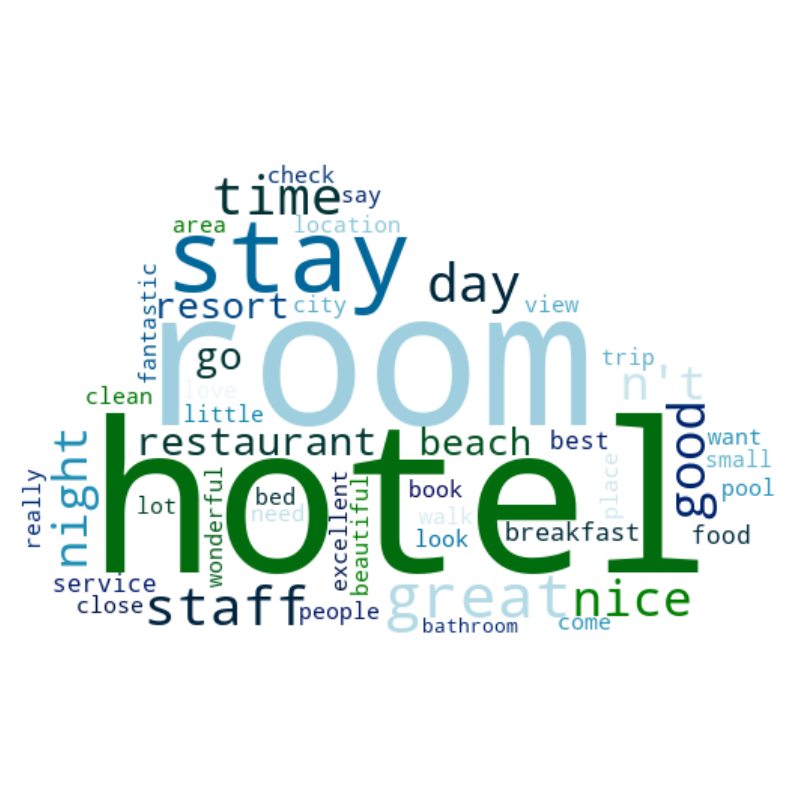

In [59]:
wordCloud_generator(train_pos, 'white', 'ocean')

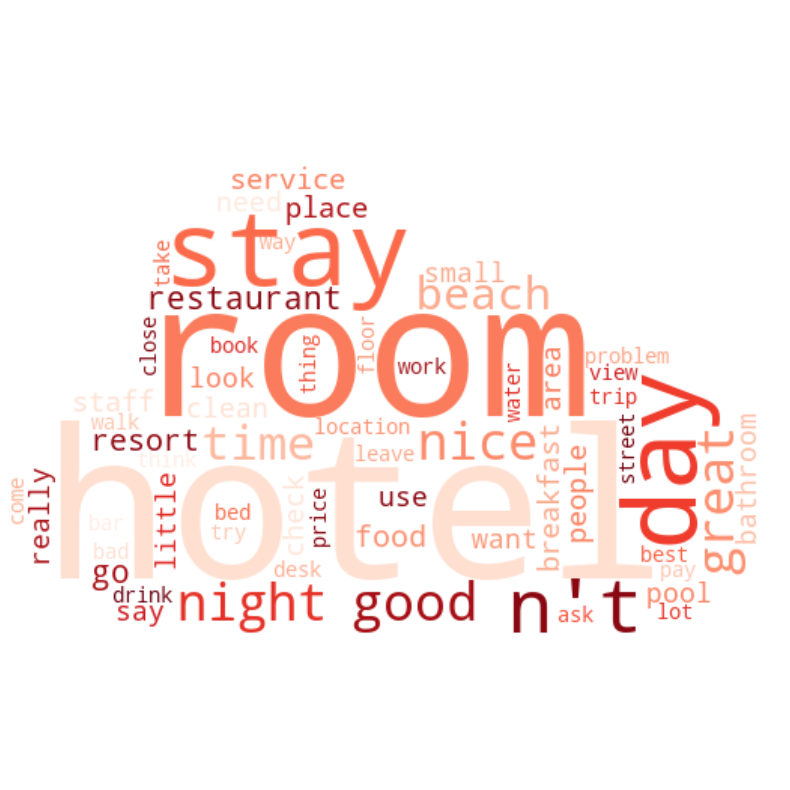

In [60]:
wordCloud_generator(train_neg, 'white', 'Reds')

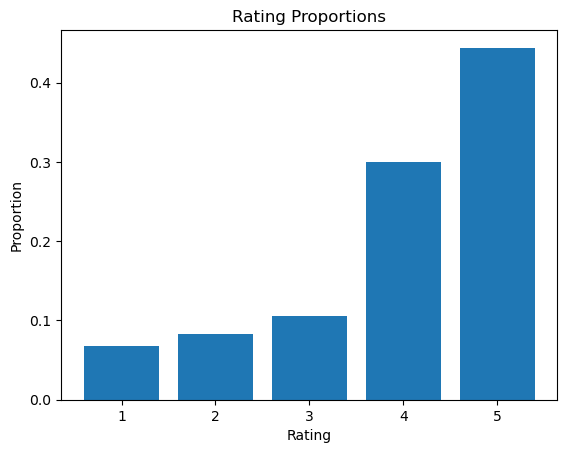

In [62]:
import matplotlib.pyplot as plt

# Calculate the rating proportions
rating_proportions = df['Rating'].value_counts(normalize=True).sort_index()

# Create the bar plot
plt.bar(rating_proportions.index, rating_proportions.values)

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.title('Rating Proportions')

# Show the plot
plt.show()
